# GEONE - GEOSCLASSIC - Examples 3D

Estimation and simulation for a continuous variable in a 3D grid, based on simple and ordinary kriging:

- estimation: estimate and standard deviation with simple and ordinary kriging
    - hard data only
    - search ellipsoid or unique neighborhood
- simulation: sequential gaussian simulation (SGS) based on simple and ordinary kriging
    - hard data and inequality data
    - search ellipsoid only

The covariance model can be

- stationary, *i.e.* any parameter (weight (or sill), ranges, orientation angles, etc.) is constant
- non-stationary, *i.e.* with some parameter (weight (or sill), ranges, orientation angles, etc.) depending on the location in the grid. *Note:* with a non-stationary covariance model
    - some functionalities such as getting the sill, range, or plotting the model are not available
    - a unique neighborhood can not be used for estimation

Simple kriging allows to specify the mean and the variance, stationary (global) or non-stationary (local). By default the mean is set to the mean of the hard data values (stationary) or zero if no hard data is present, and the variance is determined by the covariance model used and not modified.

The mean can also specified with ordinary kriging: in this case, the specified mean is used when estimation or simulation is done in a grid cell without any neighbor.

**Remark:** for examples with non-stationary covariance models, see jupyter notebook `ex_geosclassic_3d_non_stat_cov.ipynb`.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.9


In [3]:
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

## Define a covariance model in 3D: class `geone.covModel.covModel3D`

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

Azimuth (`alpha`), dip (`beta`) and plunge (`gamma`) angles can be specified in degrees: the coordinates system Ox'''y''''z''', supporting the axes of the model (ranges), is obtained from the original coordinates system Oxyz as follows:

- Oxyz       -> rotation of angle -alpha around Oz   -> Ox'y'z'
- Ox'y'z'    -> rotation of angle -beta  around Ox'  -> Ox''y''z''
- Ox''y''z'' -> rotation of angle -gamma around Oy'' -> Ox'''y'''z'''

In [4]:
cov_model = gn.covModel.CovModel3D(elem=[
    ('gaussian', {'w':8.5, 'r':[40, 20, 10]}), # elementary contribution
    ('nugget', {'w':0.5})                      # elementary contribution
    ], alpha=-30, beta=-40, gamma=20, name='model-3D example')

In [5]:
cov_model

*** CovModel3D object ***
name = 'model-3D example'
number of elementary contribution(s): 2
elementary contribution 0
    type: gaussian
    parameters:
        w = 8.5
        r = [40, 20, 10]
elementary contribution 1
    type: nugget
    parameters:
        w = 0.5
angles: alpha = -30, beta = -40, gamma = 20 (in degrees)
    i.e.: the system Ox'''y''''z''', supporting the axes of the model (ranges),
    is obtained from the system Oxyz as follows:
        Oxyz      -- rotation of angle -alpha around Oz  --> Ox'y'z'
        Ox'y'z'   -- rotation of angle -beta  around Ox' --> Ox''y''z''
        Ox''y''z''-- rotation of angle -gamma around Oy''--> Ox'''y'''z'''
*****

### Plot the covariance / variogram function of the model

Plot the covariance function by using the method `plot_model3d_volume` of the class for a 3D volume representation (based on `pyvista` module). The main axes are shown in red (x'''), green (y''') and blue (z''''), or in custom colors passing the keyword arguments `color0` (x'''),  `color1` (y'''), and `color2` (z''').

*Note:* plotting is not available for non-stationary covariance model.

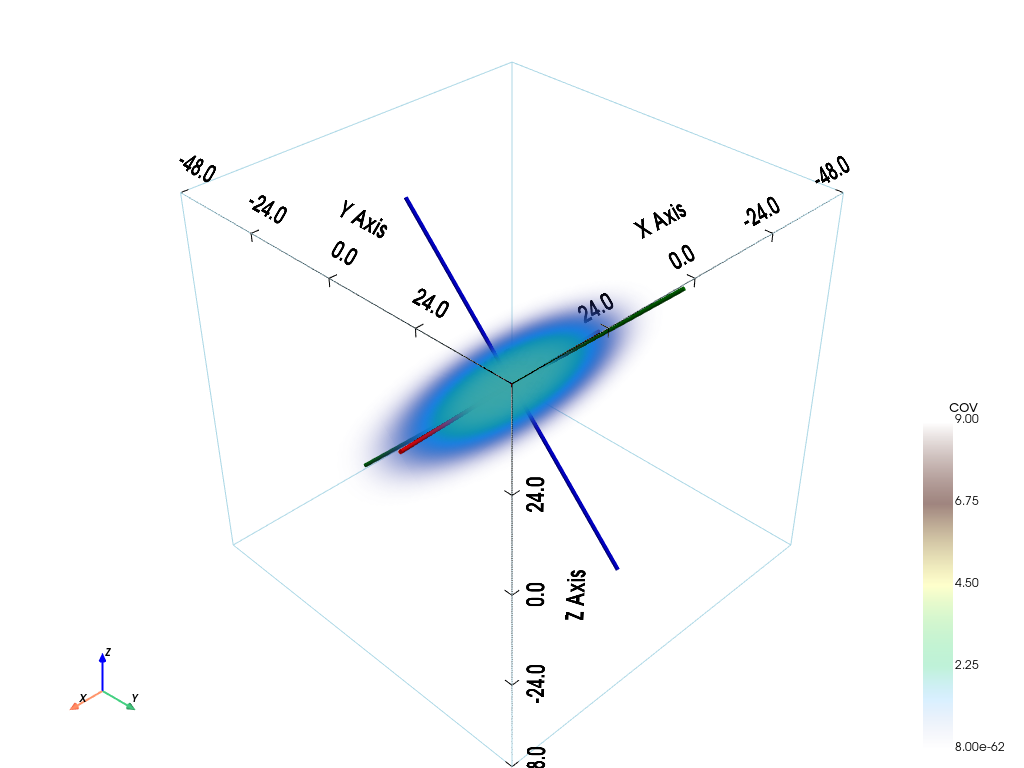

In [6]:
cov_model.plot_model3d_volume()

For a view in an intaractive figure (pop-up window), uncomment the lines in the following cell and run it.

In [7]:
%%script false --no-raise-error # skip this cell! (comment this line to run the cell)

pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
cov_model.plot_model3d_volume(plotter=pp)
pp.show() # after closing the pop-up window, the position of the camera is retrieved in output.

The method `plot_model3d_slice` of the class gives a 3D representations with slices orthogonal to the main axes and going through the origin (by default). 

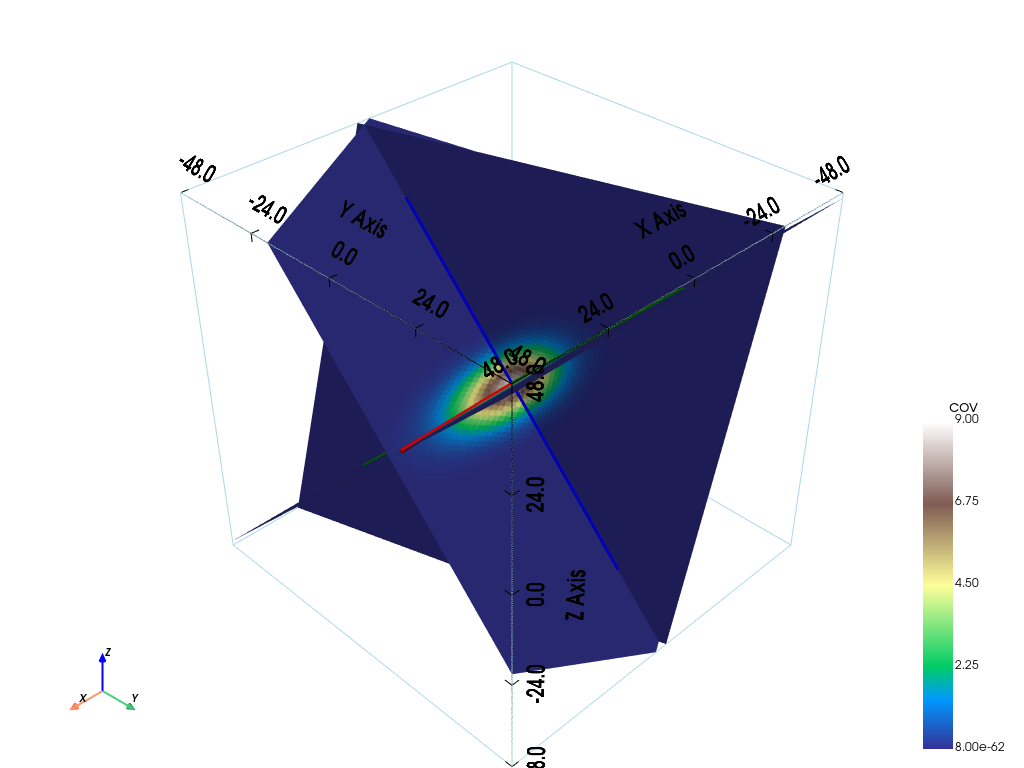

In [8]:
cov_model.plot_model3d_slice()

In [9]:
%%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Interactive figure
pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
cov_model.plot_model3d_slice(plotter=pp)
pp.show() # after closing the pop-up window, the position of the camera is retrieved in output.

For plotting slices orthogonal to each axis of the system Oxyz:

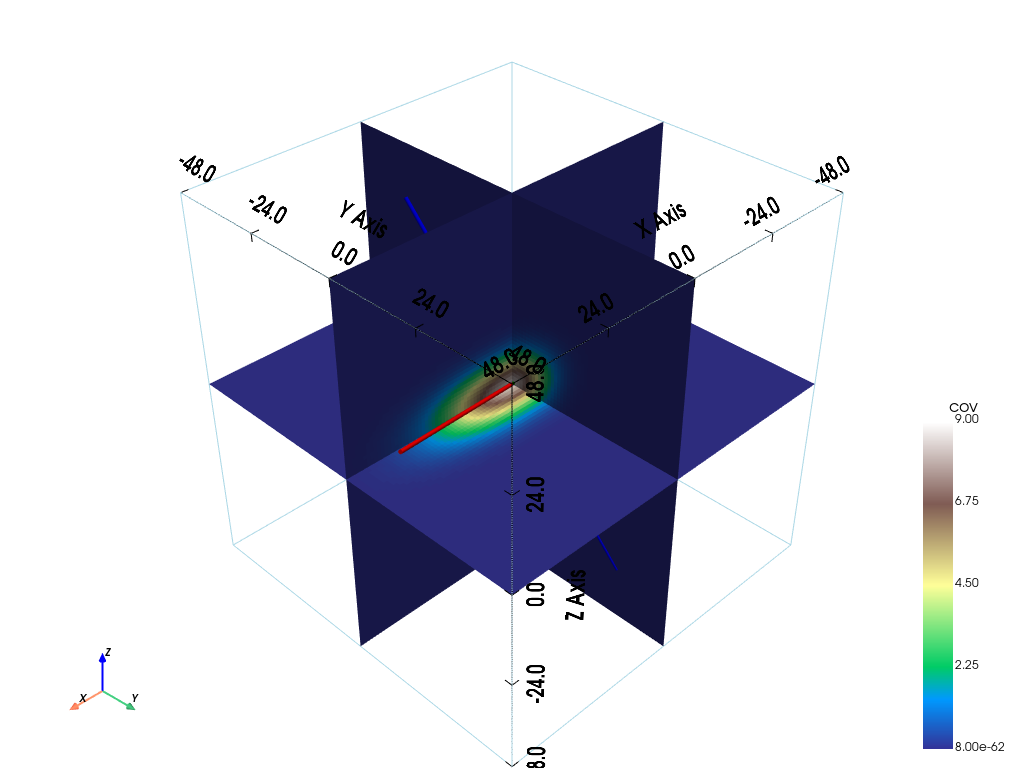

In [10]:
cov_model.plot_model3d_slice(slice_normal_x=0, slice_normal_y=0, slice_normal_z=0, slice_normal_custom=None)

In [11]:
%%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Interactive figure
pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
cov_model.plot_model3d_slice(plotter=pp, 
                             slice_normal_x=0, slice_normal_y=0, slice_normal_z=0, slice_normal_custom=None)
pp.show() # after closing the pop-up window, the position of the camera is retrieved in output.

Plot the covariance function by using the method `plot_model_curves` of the class for plotting the function along each main axis (x''', y''', and z'''). Again, the default colors can be changed by passing the keyword arguments `color0`,  `color1`, and `color2`.

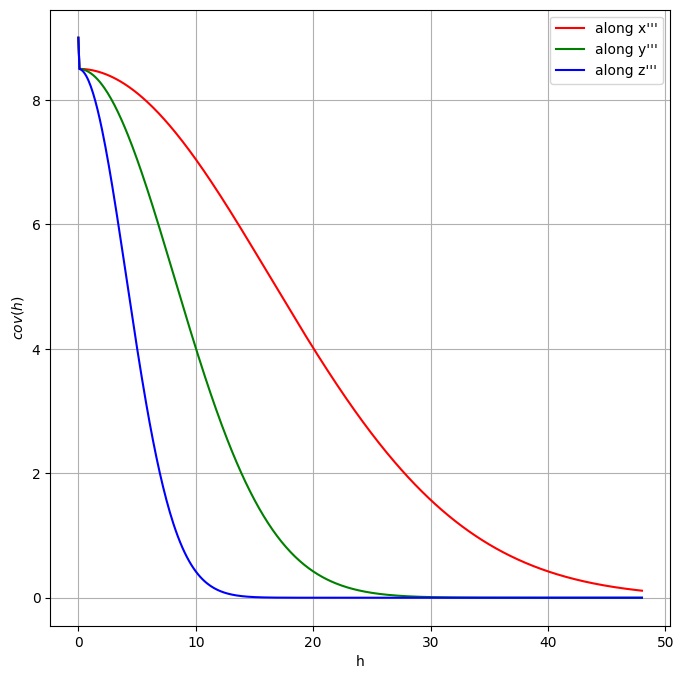

In [12]:
plt.figure(figsize=(8,8))
cov_model.plot_model_curves()
plt.show()

Plotting the variogram function: as above, but passing the keyword argument `vario=True` to the method `plot_model3d_volume` or `plot_model3d_sclice` or `plot_model_curves`.

The main axes (x''', y''' and z''') can be plotted using the method `plot_mrot`. Again, the default colors can be changed by passing the keyword arguments `color0`,  `color1`, and `color2`.

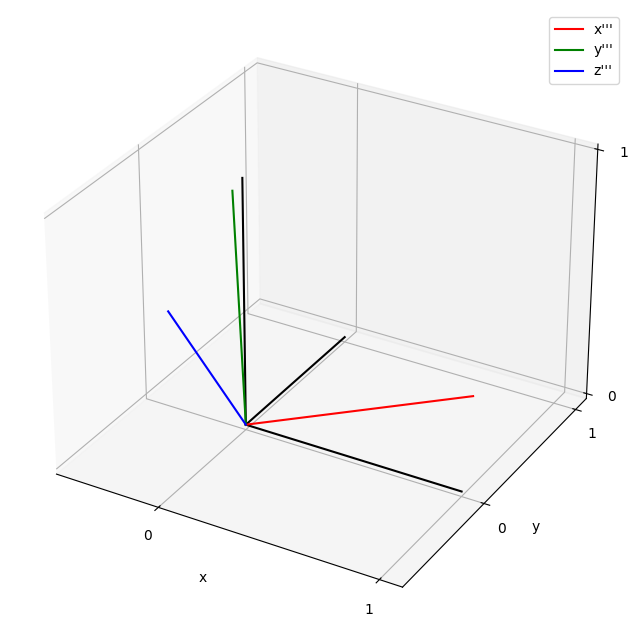

In [13]:
cov_model.plot_mrot(figsize=(8,8))

### Get the sill and ranges

Get the sill and the range along each axis in the coordinates system supporting the axes of the model.

In [14]:
w = cov_model.sill() # scalar
r = cov_model.r123() # vector (1d-array) of length 3 ranges along x'''', y''', z'''
print("Sill = {}".format(w))
print("Range along x''' = {}, along y''' = {}, along z''' = {}".format(r[0], r[1], r[2]))

Sill = 9.0
Range along x''' = 40.0, along y''' = 20.0, along z''' = 10.0


Get the maximal range along each axis of the original system Oxyz.

In [15]:
rxyz = cov_model.rxyz()  # vector (1d-array) of length 2: "max ranges" along x, y, z
print("Max. range along x = {}, along y = {}, along z = {}".format(rxyz[0], rxyz[1], rxyz[2]))

Max. range along x = 36.948833461834035, along y = 13.268278963378767, along z = 12.855752193730785


## Launching simulation and estimation in 3D
The following functions are used:

- `geone.geosclassicinterface.simulate3D` for simulation 3D (sequential Gaussian simulation, SGS)
- `geone.geosclassicinterface.estimate3D` for estimation 3D (kriging estimates and standard deviation)

These functions launch a C program running in parallel (based on *OpenMP*) for the simulation / estimation **in a grid**, after that raw conditioning data has been aggregated in the grid cells (see "Data aggregation in grid" below). The number of threads used can be specified by the optional parameter (keyword argument) `nthreads`. Specifying for this parameter a number `-n`, negative or zero, means that the total number of cpus of the system (retrieved by `os.cpu_count()`) except `n` (but at least one) will be used. By default: `nthreads=-1`.

The covariance model in 3D (class `geone.covModel.CovModel3D`) is given as first argument.

The kriging system to solve for the evaluation / simulation in one node takes into account the informed nodes within a search ellipsoid centered around the evaluated / simulated node. The *search radius* can be specified with the keyword argument `searchRadiusRelative` (float, default: 1). In general (3D), the search for neighbors (informed nodes) is limited in the ellipsoid oriented as the covariance model, of half-axes f*(r1, r2, r3), where (r1, r2, r3) denotes the (maximal) ranges along each direction.

The maximal number of neighbors retrieved is set by the keyword argument `nneigbhorMax` (int, default: `12`). The at most `nneigborMax` informed nodes within the ellipsoid are retrieved. For taking all the informed nodes within the search ellipsoid, set `nneighborMax=-1`.

The sort of the nodes within the search ellipsoid is determined by the keyword argument `searchNeighborhoodSortMode` (int: 0, 1, or 2 (default)). In general (3D), the nodes are sorted in increasing order according to:

- `searchNeighborhoodSortMode=0`: distance in the usual axes system
- `searchNeighborhoodSortMode=1`: distance in the axes sytem supporting the covariance model and accounting for anisotropy given by the ranges
- `searchNeighborhoodSortMode=2`: minus the evaluation of the covariance model

Default value for `searchNeighborhoodSortMode` is set to the greatest possible value (for a stationary covariance model: `2`, otherwise if the ranges and the orientation are stationary: `1`, otherwise: `0`).

Kriging system (for simulation or estimation) are based on simple or ordinary kriging, this is specified by the keyword argument `method` (string: 'simple_kriging' (default) or 'ordinary_kriging').

*Remark:* for estimation only (function `geone.geosclassicinterface.estimate3D`), a unique neighborhood can be used, *i.e.* all data points are taken into account in the kriging system for every node, by setting the keyword argument `use_unique_neighborhood=True` (default: `False`). In this case, the parameters `searchRadiusRelative`, `nneighborMax` and `searchNeighborhoodSortMode` are ignored (unused).

*Remark:* the keyword argument `verbose` allows to control what is displayed, `verbose=0`: minimal display, `verbose=1`: only errors (if any), `verbose=2` (default): version and warning(s) encountered, `verbose=3`: version, progress, and warning(s) encountered. Note that due to *buffering*, progress might not be displayed immediately and then could be useless.

### Data aggregation in grid
As the simulation / estimation is done in a grid, the conditioning data are first aggregated in the grid cells, i.e. data points falling in the same grid cell are aggregated in one unique value at the cell centre, using the operation specified by the parameter (keyword argument) `aggregate_data_op`, a string that can be `'sgs'` (i.e. function `geone.covModel.sgs` is used, for simulation only), `'krige'` (i.e. function `geone.covModel.krige` is used), `'min'`, `'max'`, `'mean'` (i.e. function `numpy.<aggregate_data_op>` is used), etc. Furthermore, the parameter (keyword argument) `aggregate_data_op_kwargs` is a dictionary that contains keyword arguments passed to the operation specified by `aggregate_data_op`.

*Note:* for simulation, by specifiying `aggregate_data_op='sgs'` (default), the aggregation is done for each realization (simulation), i.e. each simulation in the grid starts with a new set of values in conditioning grid cells.

*Default:* default operation is `aggregate_data_op='sgs'` for simulation and `geone.covModel.krige` for estimation, unless the covariance model has non-stationary ranges or weight (sill) in which case, `aggregate_data_op='mean'` is set.

### Launching multiple processes for simulation 
The function `geone.geosclassicinterface.simulate3D_mp` launches multiple processes. 

Specifying the number of processes, `nproc`, and the number of threads per process, `nthreads_per_proc`, this function will run `nproc` parallel processes (parallel calls of function `geone.geosclassicinterface.simulate3D`), each one using `nthreads_per_proc` threads. 

In terms of resources, this implies the use of `nproc` $\cdot$ `nthreads_per_proc` cpu(s). 

If `nproc=None` (default), `nproc` is set to $n_{cpu}-1$ (but at least $1$), where $n_{cpu}$ is the total number of cpu(s) of the system (retrieved by `multiprocessing.cpu_count()`). If `nthreads_per_proc=None`, `nthreads_per_proc` is set to the maximal integer (but at least 1) such that `nproc` $\cdot$ `nthreads_per_proc` $\leqslant n_{cpu}-1$.

Note that (if not `None`), `nproc` and `nthreads_per_proc` must be positive integers. These parameters must be set cautiously, because the product `nproc` $\cdot$ `nthreads_per_proc` can exceed $n_{cpu}$, the total number of cpu(s) of the system. Note also that, `nproc` will be reduced to the number of realizations (but at least 1) if `nproc` was set larger.

It is recommended to specify the number of parallel processes (`nproc`) and the number of threads per process (`nthreads_per_proc`).

*Remark:* the keyword argument `verbose` allows to control what is displayed, `verbose=0`: minimal display, `verbose=1`: only errors and notes (if any), `verbose=2` (default): version and warning(s) encountered.

### Alternative: wrapper `geone.multiGaussian.multiGaussianRun`
The function `geone.multiGaussian.multiGaussianRun` can be used as a wrapper; with keyword arguments

- `mode='simulation', algo='classic'`: wrapper for `geone.geosclassicinterface.simulate<d>D`
- `mode='estimation', algo='classic'`: wrapper for `geone.geosclassicinterface.estimate<d>D`

where the dimension `<d>` is automatically detected. 

Moreover, with `mode='simulation', algo='classic'`, setting also the keyword argument `use_multiprocessing=True` will launch `geone.geosclassicinterface.simulate<d>D_mp` instead of `geone.geosclassicinterface.simulate<d>D`, i.e. multiple processes will be used; by default `use_multiprocessing=False`.

### Examples

Define the simulation grid.

In [16]:
nx, ny, nz = 85, 56, 34  # number of cells
sx, sy, sz = 1.0, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

dimension = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (ox, oy, oz)

### Unconditional simulations

#### Using function `geone.geosclassicinterface.simulate3D`

In [17]:
nreal = 50
np.random.seed(321)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate3D(cov_model, dimension, spacing, origin, 
                                                        method='simple_kriging', 
                                                        searchRadiusRelative=1.0, nneighborMax=12,
                                                        nreal=nreal,
                                                        nthreads=8)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
Geos-Classic run complete
Elapsed time: 14 sec


#### Using multiple processes, function `geone.geosclassicinterface.simulate3D_mp`

In [18]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative using multiple processes
np.random.seed(321)
t1 = time.time() # start time
geosclassic_output2 = gn.geosclassicinterface.simulate3D_mp(cov_model, dimension, spacing, origin, 
                                                            method='simple_kriging', 
                                                            searchRadiusRelative=1.0, nneighborMax=12,
                                                            nreal=nreal,
                                                            nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results (both returned images are identical):
print('Identical result: {}'.format(
    np.all(geosclassic_output2['image'].val== geosclassic_output['image'].val))) # should be True

Geos-Classic running on 2 process(es)... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))
Elapsed time: 13 sec
Identical result: True


#### Using function (wrapper) `geone.multiGaussian.multiGaussianRun`

In [19]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative using wrapper geone.multiGaussian.multiGaussianRun:
np.random.seed(321)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, 
                                        mode='simulation', algo='classic', output_mode='img',
                                        method='simple_kriging', 
                                        searchRadiusRelative=1.0, nneighborMax=12,
                                        nreal=nreal,
                                        nthreads=8)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results (both returned images are identical):
print('Identical result: {}'.format(np.all(out.val== geosclassic_output['image'].val))) # should be True

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
Geos-Classic run complete
Elapsed time: 15 sec
Identical result: True


#### Using multiple processes and function (wrapper) `geone.multiGaussian.multiGaussianRun`

In [20]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative using multiple processes and wrapper geone.multiGaussian.multiGaussianRun:
np.random.seed(321)
t1 = time.time() # start time
out2 = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, 
                                         mode='simulation', algo='classic', output_mode='img',
                                         method='simple_kriging', 
                                         searchRadiusRelative=1.0, nneighborMax=12,
                                         nreal=nreal,
                                         use_multiprocessing=True, nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results (both returned images are identical):
print('Identical result: {}'.format(np.all(out2.val== geosclassic_output['image'].val))) # should be True

Geos-Classic running on 2 process(es)... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))
Elapsed time: 14 sec
Identical result: True


### Retrieve the results (and display)
The function `geone.geosclassicinterface.simulate3D` (or `geone.geosclassicinterface.simulate3D_mp`) returns the dictionary

`geosclassic_output = {'image':image, 'nwarning':nwarning, 'warnings':warnings}`

The realizations are stored in `geosclassic_output['image']`, an *image* (class `geone.img.Img`) with as many variables as realizations (the i-th variable being the i-th realization).

The total number of warning(s) encountered during the run are stored in `geosclassic_output['nwarning']` (*int*), and all the distinct warning messages are stored in `geosclassic_output['warnings']` (it is a list, possibly empty).


#### Alternative: wrapper `geone.multiGaussian.multiGaussianRun`
The function `geone.multiGaussian.multiGaussianRun` allows to choose the "format" of the output by the keyword argument `output_mode`:

- `output_mode='array'`: an numpy array is returned
- `output_mode='img'` (default): an "image" (class `geone.img.Img`) is returned

Moreover, setting the keyword argument `retrieve_warnings=True` (`False` by default), the function also returns the list of warnings encountered. More precisely, the function can be used as follows:

- `out = geone.multiGaussian.multiGaussianRun(..., retrieve_warning=False)`
- `out, warnings = geone.multiGaussian.multiGaussianRun(..., retrieve_warning=False)`

Then, `out` will contain 

- the *image* `geosclassic_output['image']` if `output_mode` is set to `'img'`
- the array `geosclassic_output['image'].val` if `output_mode` is set to `'array'`

and `warnings` will contain the list `geosclassic_output['warnings']`.

In [21]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

In [22]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

Plot the first realizations, the mean, and the standard deviation (in an *interactive figure* or *inline*).

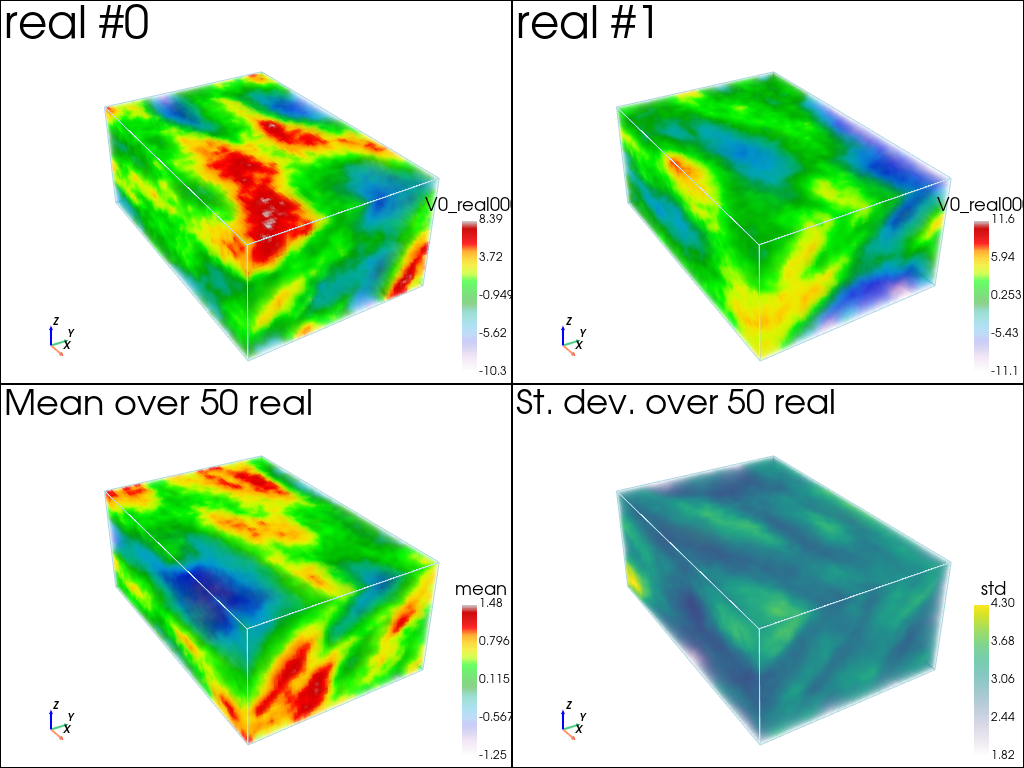

In [23]:
# Color settings
cmap = 'nipy_spectral'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_volume(
        simul, iv=i, 
        plotter=pp,
        cmap=cmap,
        text='real #{}'.format(i),
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# mean of all real
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(
    simul_mean, 
    plotter=pp,
    cmap=cmap,
    text='Mean over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    simul_std, 
    plotter=pp,
    cmap='viridis',
    text='St. dev. over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Conditional simulations (hard data)
#### Function `geone.geosclassicinterface.simulate3D[_mp]` or `geone.multiGaussian.multiGaussianRun`

Define hard data. Note that the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

In [24]:
x = np.array([[ 10.25,  20.14,  3.15], # 1st point
              [ 40.45,  10.82, 10.24], # 2nd point
              [ 30.65,  40.53, 20.24], # 3rd point
              [ 30.18,  30.14, 30.98]]) # 4th point
v = [ -3.,  2.,   5.,  -1.] # values

Launch the simulations and plot.

In [25]:
nreal = 50
np.random.seed(321)
t1 = time.time() # end time
geosclassic_output = gn.geosclassicinterface.simulate3D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='simple_kriging',
                                                        aggregate_data_op='sgs',
                                                        nreal=nreal,
                                                        nthreads=8)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
Geos-Classic run complete
Elapsed time: 16 sec


In [26]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative using multiple processes
np.random.seed(321)
t1 = time.time() # start time
geosclassic_output2 = gn.geosclassicinterface.simulate3D_mp(cov_model, dimension, spacing, origin, 
                                                            x=x, v=v, method='simple_kriging',
                                                            aggregate_data_op='sgs',
                                                            nreal=nreal,
                                                            nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results (both returned images are identical):
print('Identical result: {}'.format(
    np.all(geosclassic_output2['image'].val== geosclassic_output['image'].val))) # should be True

Geos-Classic running on 2 process(es)... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))
Elapsed time: 15 sec
Identical result: True


In [27]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative using wrapper geone.multiGaussian.multiGaussianRun:
np.random.seed(321)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, 
                                        mode='simulation', algo='classic', output_mode='img',
                                        x=x, v=v, method='simple_kriging',
                                        aggregate_data_op='sgs',
                                        nreal=nreal,
                                        nthreads=8)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results (both returned images are identical):
print('Identical result: {}'.format(np.all(out.val== geosclassic_output['image'].val))) # should be True

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
Geos-Classic run complete
Elapsed time: 15 sec
Identical result: True


In [28]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative using multiple processes and wrapper geone.multiGaussian.multiGaussianRun:
np.random.seed(321)
t1 = time.time() # start time
out2 = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, 
                                         mode='simulation', algo='classic', output_mode='img',
                                         x=x, v=v, method='simple_kriging',
                                         aggregate_data_op='sgs',
                                         nreal=nreal,
                                         use_multiprocessing=True, nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results (both returned images are identical):
print('Identical result: {}'.format(np.all(out2.val== geosclassic_output['image'].val))) # should be True

Geos-Classic running on 2 process(es)... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))
Elapsed time: 14 sec
Identical result: True


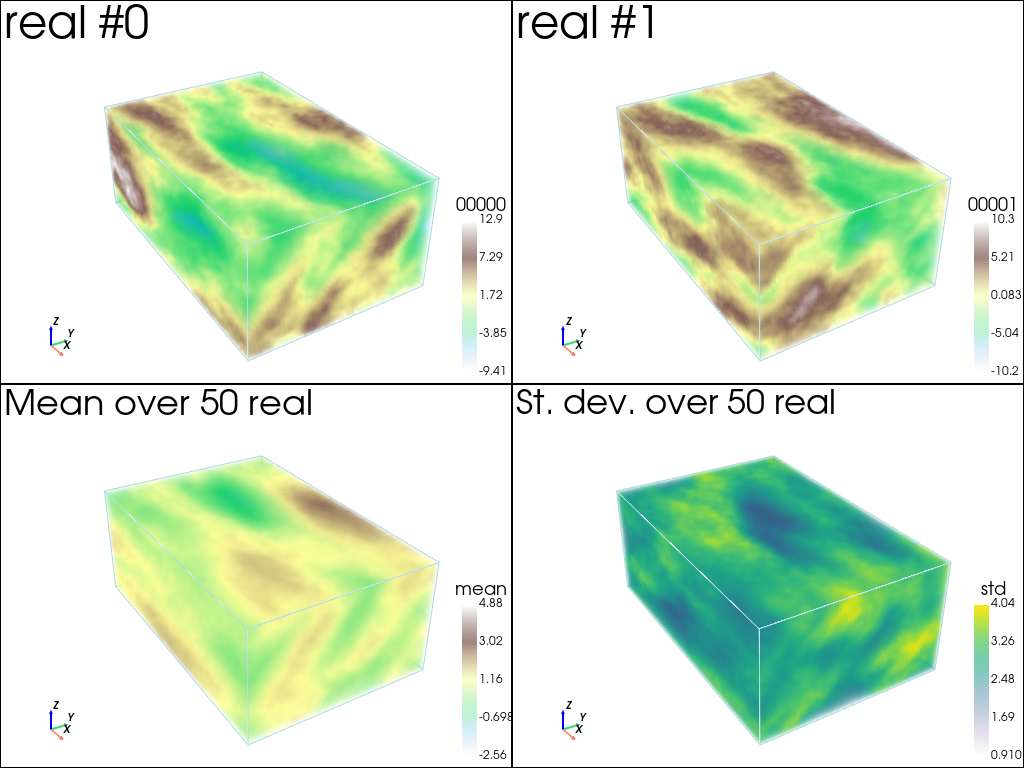

In [29]:
# Color settings
cmap = 'terrain'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_volume(
        simul, iv=i, 
        plotter=pp,
        cmap=cmap,
        text='real #{}'.format(i),
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# mean of all real
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(
    simul_mean, 
    plotter=pp,
    cmap=cmap,
    text='Mean over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    simul_std, 
    plotter=pp,
    cmap='viridis', 
    text='St. dev. over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z, ang going through the first data point, and plot the data points.

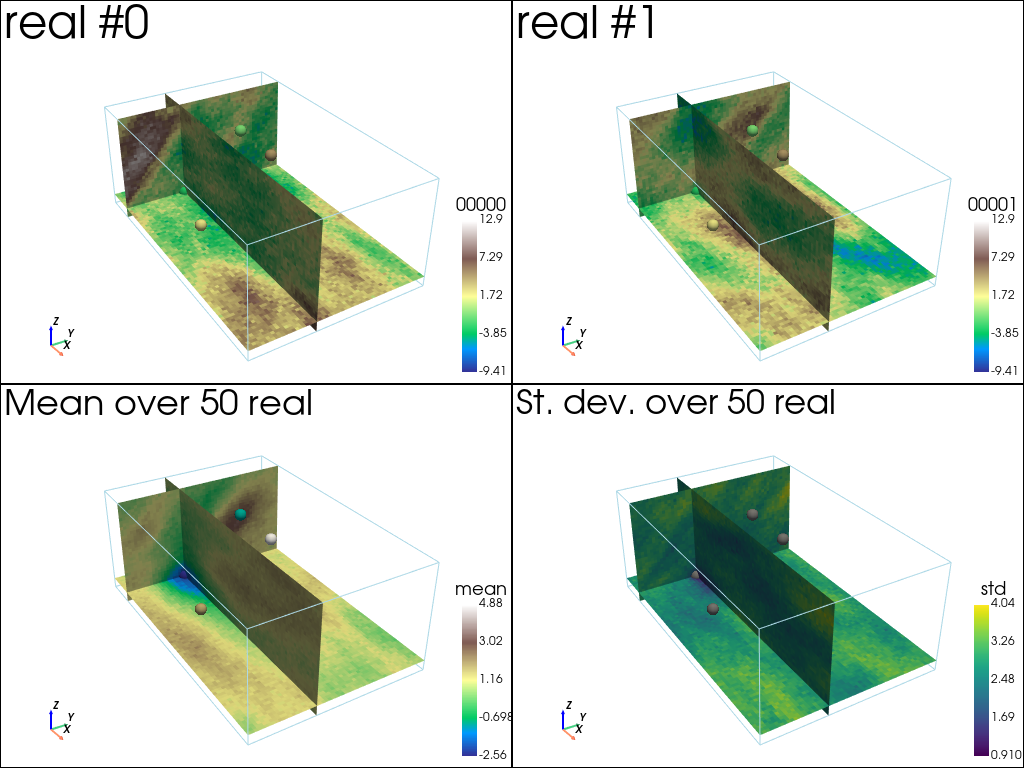

In [30]:
# Color settings
cmap = 'terrain'

cmin = np.min(simul.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(simul.vmax()[0:1]) # max value for real 0 and 1

cmin_mean = simul_mean.vmin()[0] # min value for mean
cmax_mean = simul_mean.vmax()[0] # max value for mean

# Get colors for conditioning data according to their value and color settings
data_points_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 
data_points_mean_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin_mean, cmax=cmax_mean) 

# Set points to be plotted
data_points = pv.PolyData(x)
data_points['colors'] = data_points_col

data_points_mean = pv.PolyData(x)
data_points_mean['colors'] = data_points_mean_col

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_slice(
        simul, iv=i, 
        plotter=pp,
        slice_normal_x=x[0,0],
        slice_normal_y=x[0,1],
        slice_normal_z=x[0,2],
        cmap=cmap, cmin=cmin, cmax=cmax,
        text='real #{}'.format(i),
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# mean of all real
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
    simul_mean, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap=cmap, cmin=cmin_mean, cmax=cmax_mean,
    text='Mean over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points

# standard deviation of all real
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    simul_std, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap='viridis', 
    text='St. dev. over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Estimation: kriging estimates and standard deviation
#### Function `geone.geosclassicinterface.estimate3D`

In [31]:
# Increase searchRadiusRelative to avoid "discontinuities"
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate3D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='simple_kriging',
                                                        searchRadiusRelative=1.0,
                                                        nthreads=8)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# # Or use a unique neighborhood
# t1 = time.time() # start time
# geosclassic_output = gn.geosclassicinterface.estimate3D(cov_model, dimension, spacing, origin, 
#                                                         x=x, v=v, method='simple_kriging',
#                                                         use_unique_neighborhood=True)
# t2 = time.time() # end time
# print('Elapsed time: {:.2g} sec'.format(t2-t1))

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
Geos-Classic run complete
Elapsed time: 5 sec


In [32]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative using wrapper geone.multiGaussian.multiGaussianRun
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, x=x, v=v,
                                        mode='estimation', algo='classic', output_mode='img',
                                        method='simple_kriging', searchRadiusRelative=1.0,
                                        nthreads=8)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# # Or with a unique neighborhood
# t1 = time.time() # start time
# out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, x=x, v=v,
#                                         mode='estimation', algo='classic', output_mode='img',
#                                         method='simple_kriging', use_unique_neighborhood=True)
# t2 = time.time() # end time
# print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results (both returned images are identical):
print('Identical result: {}'.format(np.all(out.val== geosclassic_output['image'].val))) # should be True

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
Geos-Classic run complete
Elapsed time: 4.9 sec
Identical result: True


### Retrieve the results (and display)
The function `geone.geosclassicinterface.estimate3D` returns the dictionary

`geosclassic_output = {'image':image, 'nwarning':nwarning, 'warnings':warnings}`

The kriging estimate and kriging standard deviation are stored in `geosclassic_output['image']`, an *image* (class `geone.img.Img`) with two variables: the first variable (index 0) is the kriging estimate, and the second variable (index 1) is the kriging standard deviation.

As for the function `geone.geosclassicinterface.simulate3D`, the warning(s) encountered during the run are stored in `geosclassic_output['nwarning']` (*int*), and all the distinct warning messages are stored in `geosclassic_output['warnings']` (it is a list, possibly empty).

In [33]:
# Retrieve the results of estimation
estim = geosclassic_output['image']

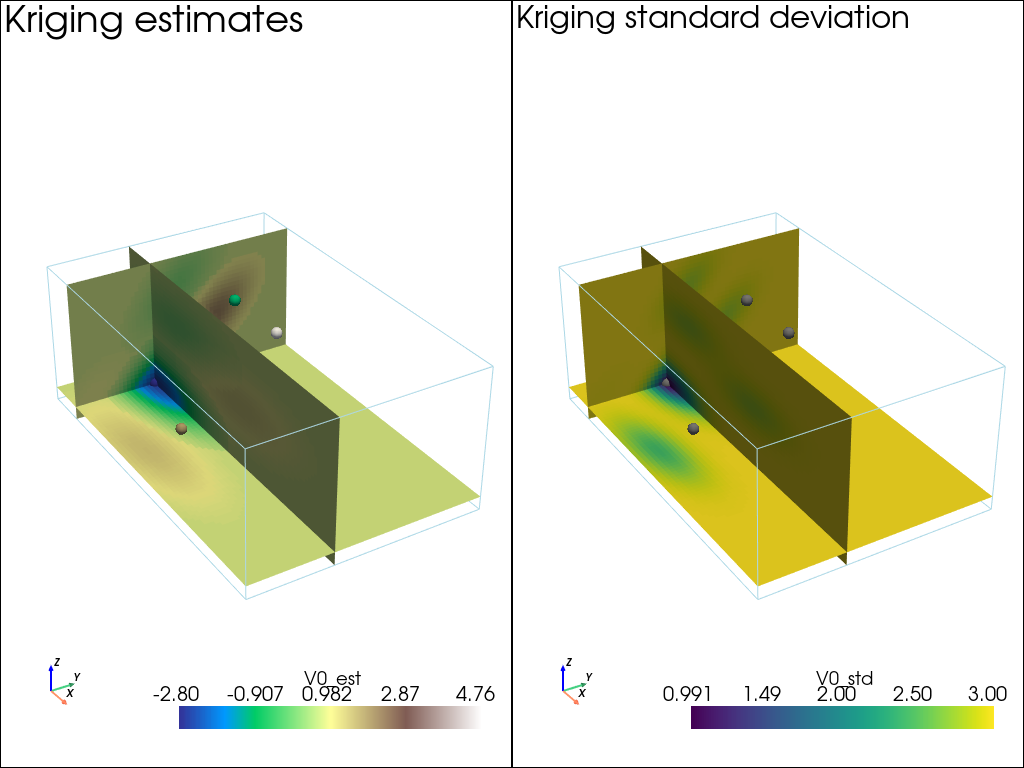

In [34]:
# Color settings
cmap = 'terrain'

cmin = estim.vmin()[0] # min value for krig. est.
cmax = estim.vmax()[0] # max value for krig. est.

# Get colors for conditioning data according to their value and color settings
data_points_krig_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 

# Set points to be plotted
data_points_krig = pv.PolyData(x)
data_points_krig['colors'] = data_points_krig_col

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,2))
# kriging estimates
pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_slice(
    estim, iv=0, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap=cmap, cmin=cmin, cmax=cmax, 
    text='Kriging estimates',
    scalar_bar_kwargs={'label_font_size':20})
pp.add_mesh(data_points_krig, rgb=True, point_size=12., render_points_as_spheres=True)

# kriging standard deviation
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    estim, iv=1, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap='viridis', 
    text='Kriging standard deviation',
    scalar_bar_kwargs={'label_font_size':20})
pp.add_mesh(data_points_krig, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Simple and ordinary kriging

In [35]:
# simulation based on simple kriging
np.random.seed(444)
geosclassic_output = gn.geosclassicinterface.simulate3D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='simple_kriging', 
                                                        nreal=1, nthreads=8)
simul_simple_krig = geosclassic_output['image']

# estimation based on simple kriging
np.random.seed(444)
geosclassic_output = gn.geosclassicinterface.estimate3D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='simple_kriging',
                                                        use_unique_neighborhood=True, nthreads=8)
estim_simple_krig = geosclassic_output['image']

# simulation based on ordinary kriging
geosclassic_output = gn.geosclassicinterface.simulate3D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='ordinary_kriging',
                                                        nreal=1, nthreads=8)
simul_ordinary_krig = geosclassic_output['image']

# estimation based on ordinary kriging
geosclassic_output = gn.geosclassicinterface.estimate3D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='ordinary_kriging', 
                                                        use_unique_neighborhood=True, nthreads=8)
estim_ordinary_krig = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
Geos-Classic run complete

Warnings encountered (5638 times in all):
#  1: WARNING 02015: solving kriging system fails (do as if no neighbor)
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
Geos-Classic run complete


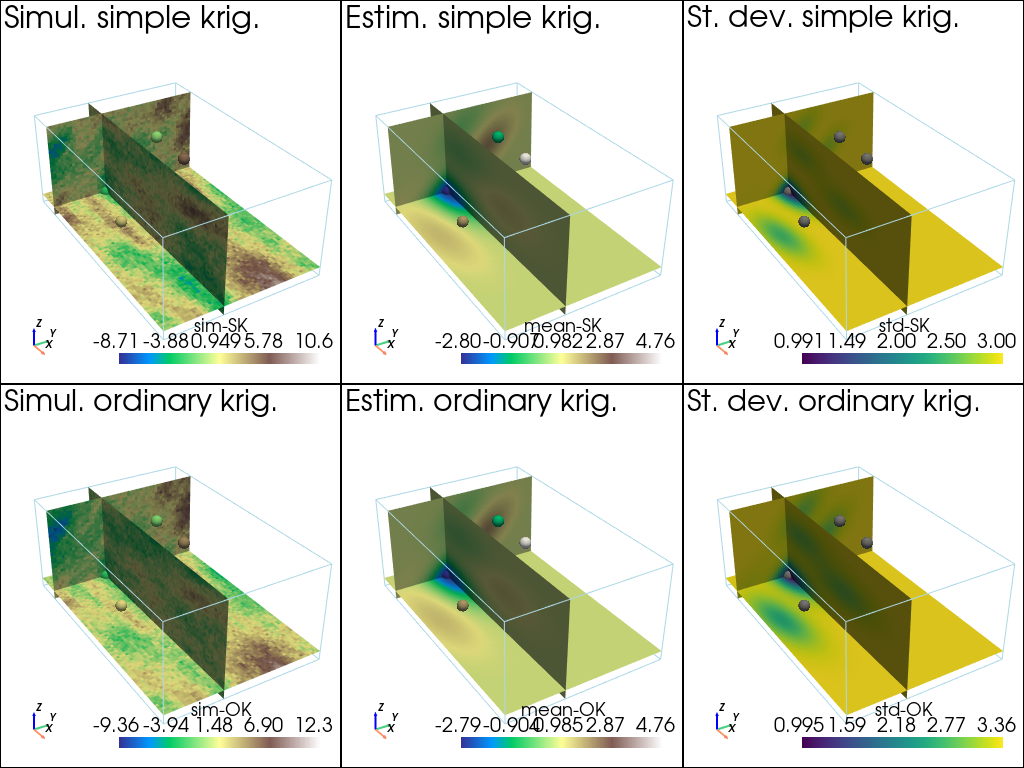

In [36]:
# Color settings
cmap = 'terrain'

cmin_sim_SK = simul_simple_krig.vmin()[0] # min value 
cmax_sim_SK = simul_simple_krig.vmax()[0] # max value

cmin_est_SK = estim_simple_krig.vmin()[0] # min value
cmax_est_SK = estim_simple_krig.vmax()[0] # max value

cmin_sim_OK = simul_ordinary_krig.vmin()[0] # min value
cmax_sim_OK = simul_ordinary_krig.vmax()[0] # max value

cmin_est_OK = estim_ordinary_krig.vmin()[0] # min value
cmax_est_OK = estim_ordinary_krig.vmax()[0] # max value

# Get colors for conditioning data according to their value and color settings
data_points_sim_SK_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin_sim_SK, cmax=cmax_sim_SK) 
data_points_est_SK_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin_est_SK, cmax=cmax_est_SK) 
data_points_sim_OK_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin_sim_OK, cmax=cmax_sim_OK) 
data_points_est_OK_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin_est_OK, cmax=cmax_est_OK) 

# Set points to be plotted
data_points_sim_SK = pv.PolyData(x)
data_points_sim_SK['colors'] = data_points_sim_SK_col

data_points_est_SK = pv.PolyData(x)
data_points_est_SK['colors'] = data_points_est_SK_col

data_points_sim_OK = pv.PolyData(x)
data_points_sim_OK['colors'] = data_points_sim_OK_col

data_points_est_OK = pv.PolyData(x)
data_points_est_OK['colors'] = data_points_est_OK_col

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3))

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_slice(
    simul_simple_krig, iv=0, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap=cmap, cmin=cmin_sim_SK, cmax=cmax_sim_SK, 
    text='Simul. simple krig.',
    scalar_bar_kwargs={'title':'sim-SK', 'label_font_size':20})
pp.add_mesh(data_points_sim_SK, rgb=True, point_size=12., render_points_as_spheres=True)

# 
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    estim_simple_krig, iv=0, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap=cmap, cmin=cmin_est_SK, cmax=cmax_est_SK, 
    text='Estim. simple krig.',
    scalar_bar_kwargs={'title':'mean-SK', 'label_font_size':20})
pp.add_mesh(data_points_est_SK, rgb=True, point_size=12., render_points_as_spheres=True)

# 
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_slice(
    estim_simple_krig, iv=1, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap='viridis',
    text='St. dev. simple krig.',
    scalar_bar_kwargs={'title':'std-SK', 'label_font_size':20})
pp.add_mesh(data_points_est_SK, color='gray', point_size=12., render_points_as_spheres=True)

pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
    simul_ordinary_krig, iv=0, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap=cmap, cmin=cmin_sim_OK, cmax=cmax_sim_OK, 
    text='Simul. ordinary krig.',
    scalar_bar_kwargs={'title':'sim-OK', 'label_font_size':20})
pp.add_mesh(data_points_sim_OK, rgb=True, point_size=12., render_points_as_spheres=True)

# 
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    estim_ordinary_krig, iv=0, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap=cmap, cmin=cmin_est_OK, cmax=cmax_est_OK, 
    text='Estim. ordinary krig.',
    scalar_bar_kwargs={'title':'mean-OK', 'label_font_size':20})
pp.add_mesh(data_points_est_OK, rgb=True, point_size=12., render_points_as_spheres=True)

# 
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    estim_ordinary_krig, iv=1, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap='viridis',
    text='St. dev. ordinary krig.',
    scalar_bar_kwargs={'title':'std-OK', 'label_font_size':20})
pp.add_mesh(data_points_est_OK, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Simulations with imposed mean and/or variance (simple kriging only)
Mean and variance in the simulation grid can be specified if simple kriging is used, they can be stationary (constant) or non-stationary. By default, the mean is set to the mean of data values (or zero if no conditioning data) (constant) and the variance is given by the sill of the variogram model (constant).

### Simulations with constant mean and variance
Set mean to $3.0$ and variance to the double of the covariance model sill.

In [37]:
# Simulation
nreal = 2
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulate3D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, 
                                                        mean=3., var=2*cov_model.sill(), 
                                                        nreal=nreal,
                                                        nthreads=8)
simul = geosclassic_output['image']

# Estimation
geosclassic_output = gn.geosclassicinterface.estimate3D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='simple_kriging',
                                                        use_unique_neighborhood=True,
                                                        mean=3., var=2*cov_model.sill(),
                                                        nthreads=8)
estim = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
Geos-Classic run complete

Warnings encountered (5638 times in all):
#  1: WARNING 02015: solving kriging system fails (do as if no neighbor)


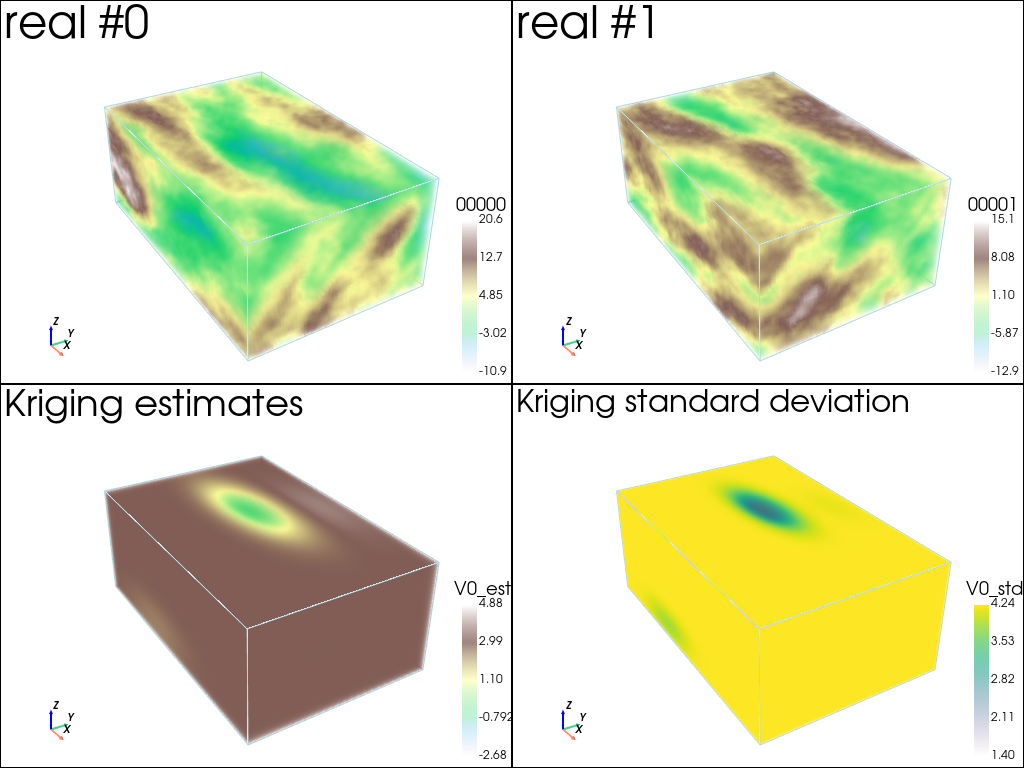

In [38]:
# Color settings
cmap = 'terrain'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_volume(
        simul, iv=i, 
        plotter=pp,
        cmap=cmap,
        text='real #{}'.format(i),
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# kriging estimates
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(
    estim, 
    plotter=pp,
    cmap=cmap, 
    text='Kriging estimates',
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# kriging standard deviation
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    estim, iv=1, 
    plotter=pp,
    cmap='viridis',
    text='Kriging standard deviation',
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z, ang going through the first data point, and plot the data points.

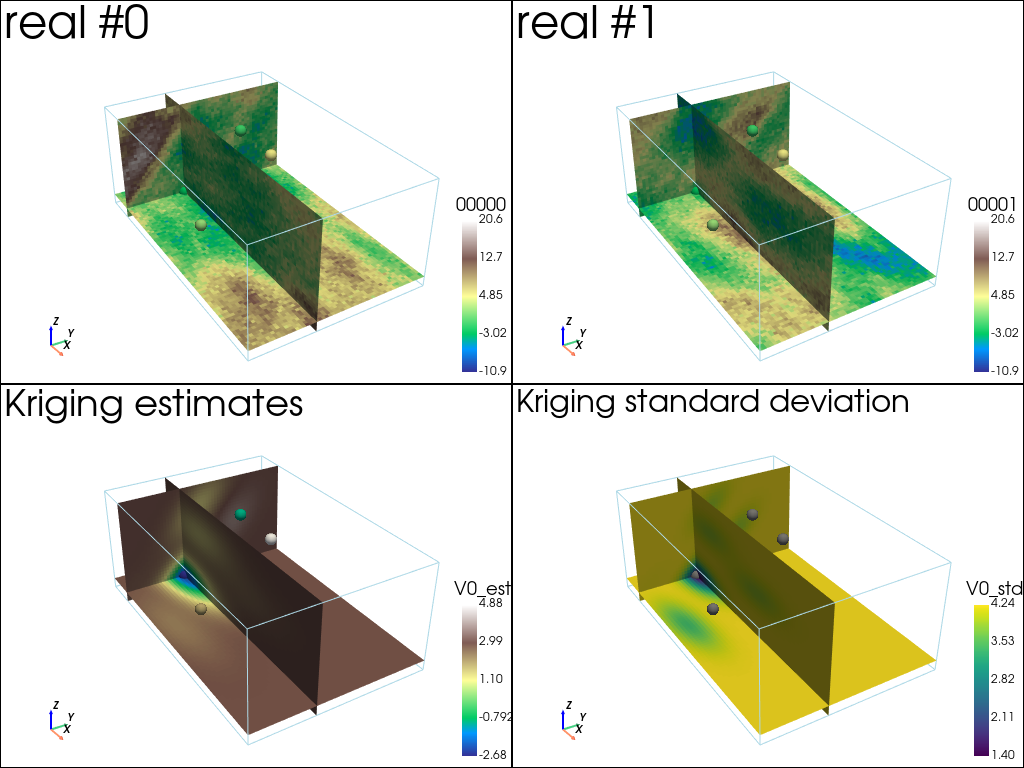

In [39]:
# Color settings
cmap = 'terrain'

cmin = np.min(simul.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(simul.vmax()[0:1]) # max value for real 0 and 1

cmin_krig = estim.vmin()[0] # min value for mean
cmax_krig = estim.vmax()[0] # max value for mean

# Get colors for conditioning data according to their value and color settings
data_points_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 
data_points_krig_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin_krig, cmax=cmax_krig) 

# Set points to be plotted
data_points = pv.PolyData(x)
data_points['colors'] = data_points_col

data_points_krig = pv.PolyData(x)
data_points_krig['colors'] = data_points_krig_col

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_slice(
        simul, iv=i, 
        plotter=pp,
        slice_normal_x=x[0,0],
        slice_normal_y=x[0,1],
        slice_normal_z=x[0,2],
        cmap=cmap, cmin=cmin, cmax=cmax,
        text='real #{}'.format(i),
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)


# kriging estimates
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
        estim, 
        plotter=pp,
        slice_normal_x=x[0,0],
        slice_normal_y=x[0,1],
        slice_normal_z=x[0,2],
        cmap=cmap, cmin=cmin_krig, cmax=cmax_krig,
        text='Kriging estimates',
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points_krig, rgb=True, point_size=12., render_points_as_spheres=True)


# kriging standard deviation
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    estim, iv=1, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap='viridis', 
    text='Kriging standard deviation',
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points_krig, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Simulations with non-stationary mean and variance
Set a varying mean and a varying variance over the simulation domain.

In [40]:
# Set an image with simulation grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Get the x, y, z coordinates of the centers of grid cell (meshgrid)
xx = im.xx()
yy = im.yy()
zz = im.zz()

# Define the mean and variance on the simulation grid
mean = 0.1*(zz + yy - xx)         # define mean on the simulation grid
var = 1 + 0.1*(xx + yy + zz)      # define variance on the simulation grid

# Set variable mean and var in image im
im.append_var([mean, var], varname=['mean', 'var'])

In [41]:
%%script false --no-raise-error # skip this cell! (comment this line to run the cell)
# Or, equivalently:

# Coordinates of the center of grid cells
xg = ox + sx*(0.5+np.arange(nx))
yg = oy + sy*(0.5+np.arange(ny))
zg = oz + sz*(0.5+np.arange(nz))

# Create a meshgrid from the center of grid cells
zz, yy, xx = np.meshgrid(zg, yg, xg, indexing='ij')

# Define the mean and variance on the simulation grid
mean = 0.1*(zz + yy - xx)         # define mean on the simulation grid
var = 1 + 0.1*(xx + yy + zz)      # define variance on the simulation grid

# Fill image for display
im = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=np.array((mean, var)))

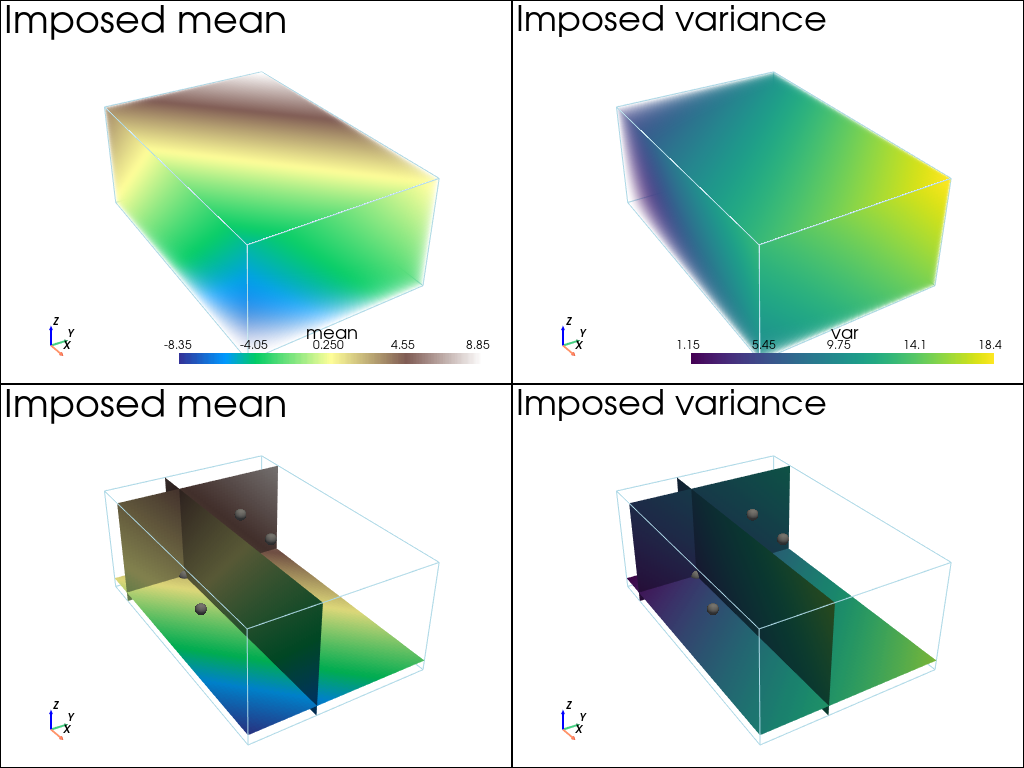

In [42]:
# Color settings
cmap = 'terrain'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# data points to be added to plot
data_points = pv.PolyData(x)

# mean (3d)
pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im, iv=0, 
    plotter=pp,
    cmap=cmap, 
    text='Imposed mean',
    scalar_bar_kwargs={'label_font_size':12})

# var
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    im, iv=1, 
    plotter=pp,
    cmap='viridis', 
    text='Imposed variance',
    scalar_bar_kwargs={'label_font_size':12})

# mean
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
    im, iv=0, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap=cmap,
    text='Imposed mean',
    scalar_bar_kwargs={'label_font_size':12})
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)


# var
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    im, iv=1, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap='viridis', 
    text='Imposed variance',
    scalar_bar_kwargs={'label_font_size':12})
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

In [43]:
# Simulation
nreal = 2
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulate3D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, 
                                                        mean=mean, var=var, 
                                                        nreal=nreal,
                                                        nthreads=8)
simul = geosclassic_output['image']

# Estimation
geosclassic_output = gn.geosclassicinterface.estimate3D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='simple_kriging',
                                                        use_unique_neighborhood=True,
                                                        mean=mean, var=var,
                                                        nthreads=8)
estim = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 8 thread(s)]
Geos-Classic run complete

Warnings encountered (5638 times in all):
#  1: WARNING 02015: solving kriging system fails (do as if no neighbor)


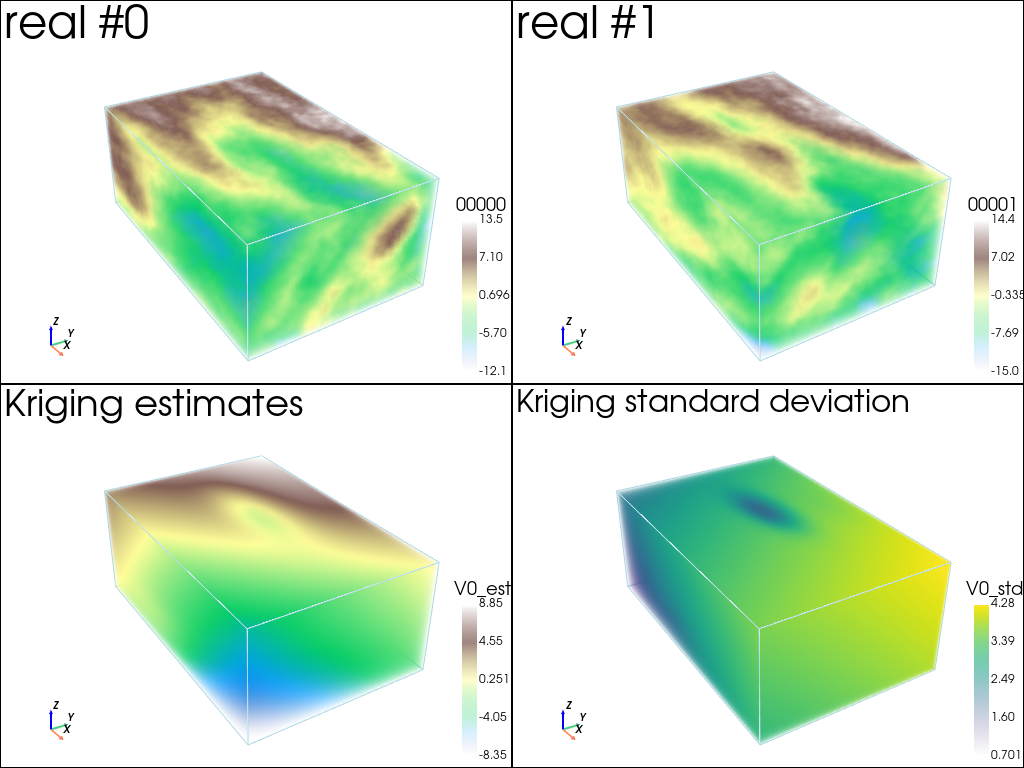

In [44]:
# Color settings
cmap = 'terrain'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_volume(
        simul, iv=i, 
        plotter=pp,
        cmap=cmap,
        text='real #{}'.format(i),
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
# kriging estimates
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(
    estim, 
    plotter=pp,
    cmap=cmap,
    text='Kriging estimates',
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# kriging standard deviation
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    estim, iv=1,
    plotter=pp,
    cmap='viridis', 
    text='Kriging standard deviation',
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z, ang going through the first data point, and plot the data points.

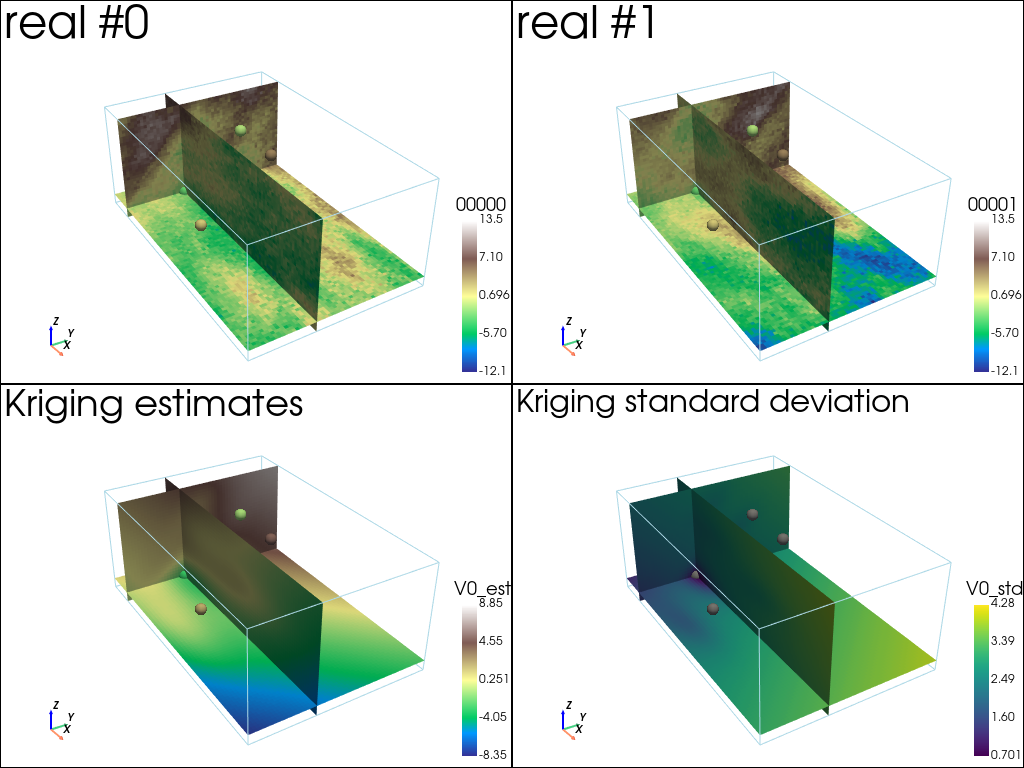

In [45]:
# Color settings
cmap = 'terrain'

cmin = np.min(simul.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(simul.vmax()[0:1]) # max value for real 0 and 1

cmin_krig = estim.vmin()[0] # min value for mean
cmax_krig = estim.vmax()[0] # max value for mean

# Get colors for conditioning data according to their value and color settings
data_points_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 
data_points_krig_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin_krig, cmax=cmax_krig) 

# Set points to be plotted
data_points = pv.PolyData(x)
data_points['colors'] = data_points_col

data_points_krig = pv.PolyData(x)
data_points_krig['colors'] = data_points_krig_col

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_slice(
        simul, iv=i, 
        plotter=pp,
        slice_normal_x=x[0,0],
        slice_normal_y=x[0,1],
        slice_normal_z=x[0,2],
        cmap=cmap, cmin=cmin, cmax=cmax,
        text='real #{}'.format(i),
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)


# kriging estimates
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
        estim, 
        plotter=pp,
        slice_normal_x=x[0,0],
        slice_normal_y=x[0,1],
        slice_normal_z=x[0,2],
        cmap=cmap, cmin=cmin_krig, cmax=cmax_krig,
        text='Kriging estimates',
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points_krig, rgb=True, point_size=12., render_points_as_spheres=True)


# kriging standard deviation
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    estim, iv=1, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap='viridis', 
    text='Kriging standard deviation',
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points_krig, color='gray', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

## Conditioning with inequality data (simulation only)

Simulation can be done with usual hard data and inequality data consisting in a lower and/or upper bound at some points.

The conditioning locations with inequality data are first simulated (with truncated gaussian distribution) sequentially. Then, these locations are re-simulated following a new path as many times as needed (Gibbs sampler); the total number of paths will be between `nGibbsSamplerPathMin` and `nGibbsSamplerPathMax` (keyword arguments, default: 50 and 200 respectively).

Define hard data and inequality data with minimal value and inequality with maximal value. Note that the conditioning values (hard, min. or max.) will be attached to the grid cells containing the corresponding conditioning locations.

In [46]:
# Hard data
x = np.array([[ 10.25,  20.14,  3.15], # 1st point
              [ 40.45,  10.82, 10.24], # 2nd point
              [ 30.65,  40.53, 20.24], # 3rd point
              [ 30.18,  30.14, 30.98]]) # 4th point
v = [ -3.,  2.,   5.,  -1.] # values

# Inequality data
xIneqMin = np.array([[ 10.25,  10.35,  6.51],   # 1st point
                     [ 50.15,  20.35, 20.85]])  # 2nd point
vIneqMin = [4., -2.2]  # lower bounds

xIneqMax = np.array([[ 65.54,   5.12,  3.97],   # 1st point
                     [ 50.23,  20.41, 20.86]])  # 2nd point
vIneqMax = [-4.1, -2.]  # upper bounds
# Note: second inequality data point has a lower bound and an upper bound

In [47]:
nreal = 50
np.random.seed(321)
t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate3D_mp(cov_model, dimension, spacing, origin, 
                                                           x=x, v=v, 
                                                           xIneqMin=xIneqMin, vIneqMin=vIneqMin,
                                                           xIneqMax=xIneqMax, vIneqMax=vIneqMax,
                                                           method='simple_kriging', nreal=nreal,
                                                           nproc=2, nthreads_per_proc=4)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

Geos-Classic running on 2 process(es)... [VERSION 2.0 / BUILD NUMBER 20240322 / OpenMP 4 thread(s)]
Geos-Classic run complete (all process(es))
Elapsed time: 15 sec


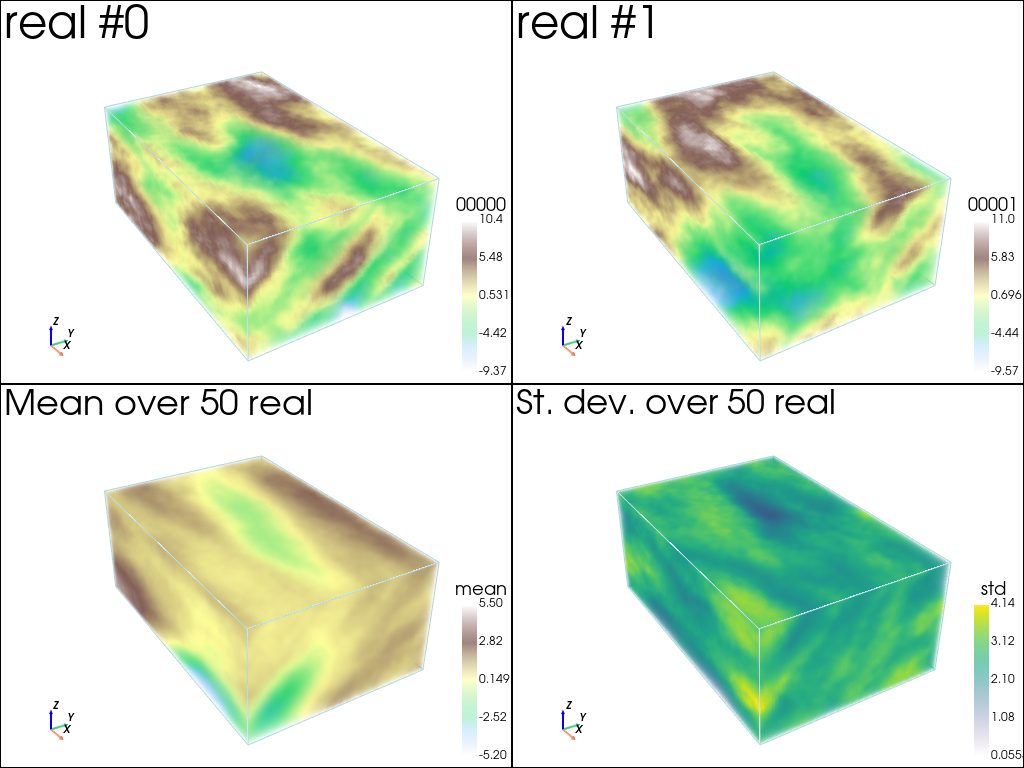

In [48]:
# Color settings
cmap = 'terrain'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_volume(
        simul, iv=i, 
        plotter=pp,
        cmap=cmap,
        text='real #{}'.format(i),
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# mean of all real
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_volume(
    simul_mean, 
    plotter=pp,
    cmap=cmap,
    text='Mean over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    simul_std, 
    plotter=pp,
    cmap='viridis', 
    text='St. dev. over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

Plot slices orthogonal to each axis x, y, z, ang going through the first data point, and plot the data points.

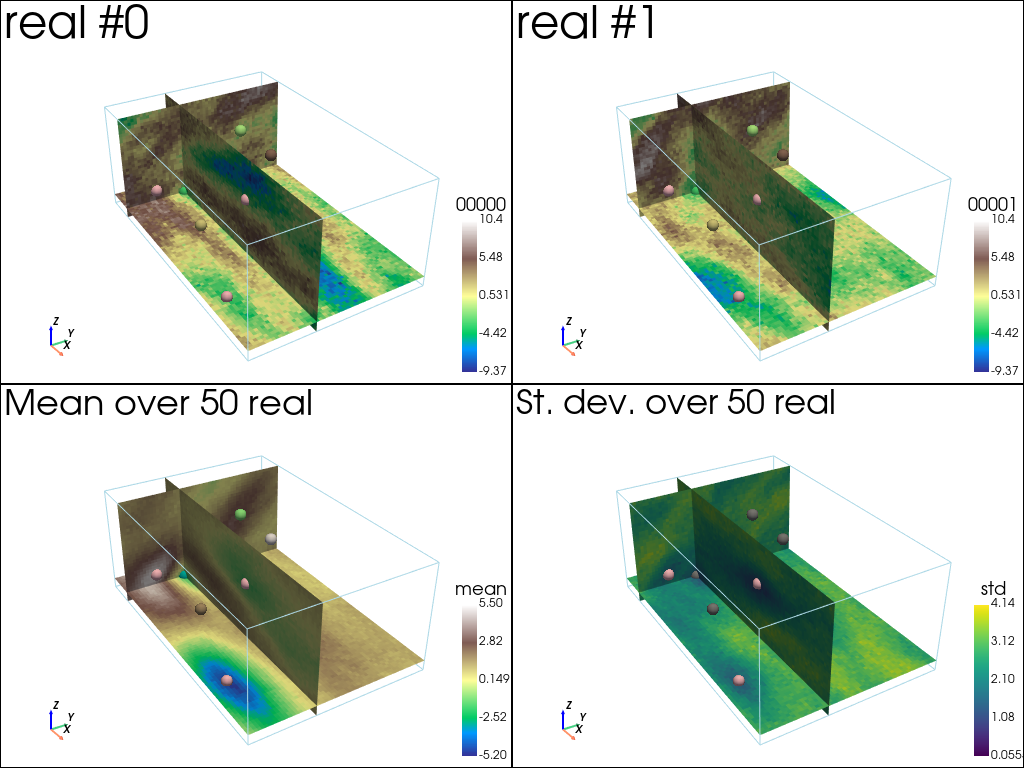

In [49]:
# Color settings
cmap = 'terrain'

cmin = np.min(simul.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(simul.vmax()[0:1]) # max value for real 0 and 1

cmin_mean = simul_mean.vmin()[0] # min value for mean
cmax_mean = simul_mean.vmax()[0] # max value for mean

# Get colors for conditioning data according to their value and color settings
data_points_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 
data_points_mean_col = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin_mean, cmax=cmax_mean) 

# Set points to be plotted
data_points = pv.PolyData(x)
data_points['colors'] = data_points_col

data_points_mean = pv.PolyData(x)
data_points_mean['colors'] = data_points_mean_col

data_points_ineq_min = pv.PolyData(xIneqMin)
data_points_ineq_max = pv.PolyData(xIneqMax)

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# 2 first reals
for i in (0, 1):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_slice(
        simul, iv=i, 
        plotter=pp,
        slice_normal_x=x[0,0],
        slice_normal_y=x[0,1],
        slice_normal_z=x[0,2],
        cmap=cmap, cmin=cmin, cmax=cmax,
        text='real #{}'.format(i),
        scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)
    pp.add_mesh(data_points_ineq_min, color='pink', point_size=12., render_points_as_spheres=True)
    pp.add_mesh(data_points_ineq_max, color='pink', point_size=12., render_points_as_spheres=True)

# mean of all real
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
    simul_mean, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap=cmap, cmin=cmin_mean, cmax=cmax_mean,
    text='Mean over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True)
pp.add_mesh(data_points_ineq_min, color='pink', point_size=12., render_points_as_spheres=True)
pp.add_mesh(data_points_ineq_max, color='pink', point_size=12., render_points_as_spheres=True)

# standard deviation of all real
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    simul_std, 
    plotter=pp,
    slice_normal_x=x[0,0],
    slice_normal_y=x[0,1],
    slice_normal_z=x[0,2],
    cmap='viridis', 
    text='St. dev. over {} real'.format(nreal),
    scalar_bar_kwargs={'vertical':True, 'label_font_size':12})
pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True)
pp.add_mesh(data_points_ineq_min, color='pink', point_size=12., render_points_as_spheres=True)
pp.add_mesh(data_points_ineq_max, color='pink', point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(165, -100, 115)) # position of the camera can be specified

### Check that conditioning data are honoured

In [50]:
# Compute min and max (pixel-wise)
simul_min = gn.img.imageContStat(simul, op='min')
simul_max = gn.img.imageContStat(simul, op='max')

# Get index of conditioning location in simulation grid
hd_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], sx, sy, sz, ox, oy, oz) for xx in x]
ineqMin_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], sx, sy, sz, ox, oy, oz) for xx in xIneqMin]
ineqMax_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], sx, sy, sz, ox, oy, oz) for xx in xIneqMax]

# Min and max value at hard data
min_value_at_hd = np.asarray([simul_min.val[0][grid_index[::-1]] for grid_index in hd_grid_index])
max_value_at_hd = np.asarray([simul_max.val[0][grid_index[::-1]] for grid_index in hd_grid_index])
print('Hard data value:\n{}'.format(v))
print('Min and max value at hard data:\n{}\n{}'.format(
    min_value_at_hd, max_value_at_hd))
print('Hard data, abs error max: {}\n'.format(max(np.ptp(min_value_at_hd - v), np.ptp(max_value_at_hd - v))))
      
# Min and max value at inequality data with minimal value
min_value_at_ineqMin = np.asarray([simul_min.val[0][grid_index[::-1]] for grid_index in ineqMin_grid_index])
max_value_at_ineqMin = np.asarray([simul_max.val[0][grid_index[::-1]] for grid_index in ineqMin_grid_index])
print('Minimal data value:\n{}'.format(vIneqMin))
print('Min and max value at inequality data with minimal value:\n{}\n{}'.format(
    min_value_at_ineqMin, max_value_at_ineqMin))
print('All min data value honoured ? {}\n'.format(np.all(min_value_at_ineqMin > vIneqMin)))

# Min and max value at inequality data with maximal value
min_value_at_ineqMax = np.asarray([simul_min.val[0][grid_index[::-1]] for grid_index in ineqMax_grid_index])
max_value_at_ineqMax = np.asarray([simul_max.val[0][grid_index[::-1]] for grid_index in ineqMax_grid_index])
print('Maximal data value:\n{}'.format(vIneqMax))
print('Min and max value at inequality data with maximal value:\n{}\n{}'.format(
    min_value_at_ineqMax, max_value_at_ineqMax))
print('All max data value honoured ? {}'.format(np.all(max_value_at_ineqMax < vIneqMax)))

Hard data value:
[-3.0, 2.0, 5.0, -1.0]
Min and max value at hard data:
[-4.50983391 -0.21689207  1.55945121 -3.84402634]
[0.10573112 4.31427867 6.95740772 1.64801889]
Hard data, abs error max: 1.9307148731374357

Minimal data value:
[4.0, -2.2]
Min and max value at inequality data with minimal value:
[ 4.11114428 -2.18604966]
[ 8.38795395 -2.00434926]
All min data value honoured ? True

Maximal data value:
[-4.1, -2.0]
Min and max value at inequality data with maximal value:
[-7.58113082 -2.18604966]
[-4.13068736 -2.00434926]
All max data value honoured ? True
